# Capsule Network with Dynamic Routing (CapsNet) - PyTorch 1.4

In [1]:
import numpy as np
import torch 
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

### Visualizing Dataset

In [2]:
sample_data = MNIST('./mnist_data/', download=True, train=True)

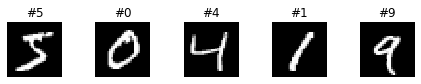

In [3]:
#show some samples
for i in range(5):
    
    sample = sample_data[i] #contain PIL images and corresponding labels.
    
    ax = plt.subplot(1,5,i+1)
    plt.tight_layout()
    ax.set_title("#{}".format(sample[1]))
    ax.axis('off')
    plt.imshow(sample[0], cmap='gray')

### CapsNet

In [4]:
batch_size           = 180
learning_rate        = 1e-4
epsilon              = 1e-9
height,width, depth  = 28,28,1
epoch                = 2
num_labels           = 10
primary_caps_vlength = 8
digit_caps_vlength   = 16
routing_iteration    = 3
m_plus               = 0.9
m_minus              = 0.1
lambda_              = 0.5
reg_scale            = 0.005
device               = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def squash(capsules):
    '''
    Activation function for CapsNet.
    '''
    
    dot_prod      = torch.sum(capsules**2, axis=-2, keepdim=True) #dot product
    scalar_factor = dot_prod/(1+dot_prod)/torch.sqrt(dot_prod+epsilon)
    squashed      = scalar_factor * capsules
    
    return squashed

In [6]:
def one_hot_encoder(labels, num_labels = num_labels):
    '''
    Convert the given integer batches to batches of one-hot encodings.
    '''
    
    one_hot_zeros = torch.zeros((labels.size(0), num_labels)).to(device)
    one_hot_labels = one_hot_zeros.scatter_(1, labels.view(-1,1), 1.)
    
    return one_hot_labels


def margin_loss(v_lengths, y, lambda_=lambda_):
    '''
    Calculates the classification loss of the network.
    '''
    
    max_l = torch.max(torch.zeros(1).to(device), 0.9 - v_lengths)**2
    max_r = torch.max(torch.zeros(1).to(device), v_lengths - 0.1)**2
    
    max_l = max_l.view(y.size(0), -1)
    max_r = max_r.view(y.size(0), -1)
    
    T_c = y #label
    
    L_c = T_c * max_l + lambda_*(1-T_c)*max_r
    
    margin_loss = torch.mean(torch.sum(L_c, dim=1))
    
    return margin_loss


def reconstruction_loss(ori_imgs, decoded, reg_scale = reg_scale):
    '''
    Calculates the reconstruction loss of the network.
    '''
    
    origin = ori_imgs.view(ori_imgs.size(0), -1)
    
    #mean squared error between the original vector and the reconstructed vector.
    recon_loss = reg_scale * nn.MSELoss()(decoded, origin) 
    
    return recon_loss



def classification_accuracy(v_lengths, y):
    '''
    Calculates the classification accuracy.
    '''
    
    softmaxed_res = nn.Softmax(dim=1)(v_lengths) #softmax the magnitudes of the vectors.
    
    #get the index of the highest magnitude vector.
    pred_index = torch.argmax(softmaxed_res, 1).view(v_lengths.size(0),1) 
    
    correct_pred = torch.eq(pred_index, torch.argmax(y,1).view(y.size(0), 1))
    
    accuracy = torch.mean(torch.as_tensor(correct_pred).type(torch.DoubleTensor))
    
    return accuracy

In [7]:
class PrimaryCapsules(nn.Module):
    '''
    Converts the output from previously defined conv layers into capsules.
    '''
    
    def __init__(self, primary_caps_length=primary_caps_vlength):
        
        super(PrimaryCapsules, self).__init__()
        
        self.caps_length = primary_caps_length
    
    def forward(self, x):
        '''
        Transform the given feature vector to capsules and apply the squashing act. func.
        '''
        return squash(x.view(x.size(0), -1, self.caps_length, 1))

In [8]:
class DigitCapsules(nn.Module):
    '''
    Uses the Primary Capsules for routing process and returns the output after the process.
    '''
    
    def __init__(self, num_capsules,
                       input_caps_length = primary_caps_vlength,
                       digit_caps_length = digit_caps_vlength, 
                       num_labels        = num_labels,
                       routing_iter      = routing_iteration,
                       device            = device):
        
        super(DigitCapsules, self).__init__()
        
        self.in_caps_length  = input_caps_length
        self.in_caps_num     = num_capsules
        self.out_caps_length = digit_caps_length
        self.out_caps_num    = num_labels
        self.routing_iter    = routing_iter
        
        #Initialize the weight and bias for the transformation of capsules later
        self.weight = nn.Parameter(0.05 * torch.randn(1, self.in_caps_num, self.out_caps_num, 
                                                     self.in_caps_length, self.out_caps_length))
        
        self.bias  = nn.Parameter(0.05 * torch.randn(1, 1, self.out_caps_num, self.out_caps_length, 1))
        
        self.device = device
        
        
    
    def forward(self, x):
        '''
        Perform the transformation of capsules + dynamic routing.
        '''
        #copy the weight [batch_size] times to perform batch operation.
        tiled_weights = self.weight.repeat(x.size(0), 1, 1, 1, 1) 
        #increase the dimension of the input capsules to perform batch multiplication.
        tiled_in_caps = x[:,:, None, :, :].repeat(1,1,self.out_caps_num, 1, 1)
        
        u_hat = torch.matmul(torch.transpose(tiled_weights, -1, -2), tiled_in_caps).to(self.device)
        
        u_hat_detached = u_hat.detach() #no gradient flow
        
        b_ij = nn.Parameter(torch.zeros(x.size(0), x.size(1), self.out_caps_num, 1, 1), 
                            requires_grad=False).to(self.device) #coefficients for dynamic routing. No gradients.
        
        
        for r_iter in range(self.routing_iter):
            
            c_ij = nn.functional.softmax(b_ij, dim=2)
            
            if r_iter == self.routing_iter - 1: #final iteration
                
                s_j = torch.mul(c_ij, u_hat)
                
                s_j = torch.sum(s_j, dim=1, keepdim=True) + self.bias
                
                v_j = squash(s_j)
        
            else:
                
                s_j = torch.mul(c_ij, u_hat_detached)
                
                s_j = torch.sum(s_j, dim=1, keepdim=True) + self.bias
                
                v_j = squash(s_j)
                
                v_j_tiled = v_j.repeat(1, self.in_caps_num, 1, 1, 1)
                
                product = u_hat_detached * v_j_tiled
                
                u_produce_v = torch.sum(product, dim=3, keepdim=True)
                
                b_ij = b_ij + u_produce_v
                
        return v_j

In [9]:
class ReconstructionNetwork(nn.Module):
    '''
    Used to reconstruct the image back from the final layer capsule.
    '''
    
    def __init__(self, num_labels        = num_labels,
                       final_capsule_num = digit_caps_vlength,
                       fc1_num           = 512,
                       fc2_num           = 1024,
                       img_height        = height,
                       img_width         = width,
                       img_depth         = depth):
        
        super(ReconstructionNetwork, self).__init__()
        
        self.num_labels       = num_labels
        self.input_neuron_num = self.num_labels*final_capsule_num
        self.fc1_out_num = fc1_num
        self.fc2_in_num  = fc1_num
        self.fc2_out_num = fc2_num
        self.fc3_in_num  = fc2_num
        self.output_size = img_height*img_width*img_depth
        
        #3 fully connected layers with (28*28=784) sized output to represent the original image.
        self.fc_layers = nn.Sequential(
                                    nn.Linear(self.input_neuron_num, self.fc1_out_num),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(self.fc2_in_num, self.fc2_out_num),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(self.fc3_in_num, self.output_size),
                                    nn.Sigmoid() #the output will be in range of 0-1
                                    )
    
        
    def forward(self, x, y):
        
        #only retain the value of the capsule that corresponds to the true label.
        masked_capsule = torch.squeeze(x, dim=-1) * y.view(-1, self.num_labels, 1) 

        capsule_reshaped = masked_capsule.view(y.size(0), self.input_neuron_num)
        
        decoded = self.fc_layers(capsule_reshaped)
        
        return decoded

**CapsNet Model**

In [10]:
class CapsuleNetwork(nn.Module):
    '''
    Entire Capsule Network that make use of PrimaryCapsules and DigitCapsules classes above.
    '''
    
    def __init__(self, conv1_output_depth = 256, 
                       conv2_output_depth = 256, 
                       kernel_size_1      = 9,
                       kernel_size_2      = 9,
                       padding_1          = 0,
                       padding_2          = 0,
                       stride_1           = 1,
                       stride_2           = 2,
                       in_channel         = depth):
        
        super(CapsuleNetwork, self).__init__()
        
        #Convolutional layers
        self.cnn_blocks = nn.Sequential(
                                        nn.Conv2d(1, conv1_output_depth, kernel_size=kernel_size_1, 
                                                  padding=padding_1, stride=stride_1),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(conv1_output_depth, conv2_output_depth, 
                                                  kernel_size=kernel_size_2, 
                                                  padding=padding_2, stride=stride_2),
                                        nn.ReLU(inplace=True)
                                        )
        self.primary_caps = PrimaryCapsules() #init primary caps class
        self.digit_caps   = DigitCapsules(num_capsules=1152) #init digit caps class
        self.recon_net    = ReconstructionNetwork()
        
        for m in self.modules(): #initialize fully-connected layers weights.
            
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            
        
    
    def forward(self, x, y):
        
        conv_outputs       = self.cnn_blocks(x) #convolutional operation
        primary_caps_layer = self.primary_caps(conv_outputs) #primary capsules
        digit_caps_layer   = self.digit_caps(primary_caps_layer) #digit capsules
        
        digits = torch.squeeze(digit_caps_layer, dim=1)
        
        #calculate the magnitudes/lengths of the capsules.
        v_lengths = torch.sqrt(torch.sum(digits**2, dim=2, keepdim=True) + 1e-8) 
        
        one_hot_y = one_hot_encoder(y).detach()
        
        
        print(y)
        print(one_hot_y)
        
        classification_loss = margin_loss(v_lengths, one_hot_y)
        
        acc = classification_accuracy(v_lengths, one_hot_y)
        
        #reconstructed vector
        decoded = self.recon_net(digits, one_hot_y)
        
        recon_loss = reconstruction_loss(x, decoded)
        
        total_loss = classification_loss + recon_loss
        
        return (total_loss, acc, v_lengths, decoded)

        
caps_model = CapsuleNetwork().to(device)
optimizer = Adam(caps_model.parameters(), lr=learning_rate)
lr_decay = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

try:
    caps_model.load_state_dict(torch.load('./capsnet.pth'))
except:
    print("Model not loaded!")

print(caps_model)

CapsuleNetwork(
  (cnn_blocks): Sequential(
    (0): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
    (3): ReLU(inplace=True)
  )
  (primary_caps): PrimaryCapsules()
  (digit_caps): DigitCapsules()
  (recon_net): ReconstructionNetwork(
    (fc_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)


### Model Training

In [11]:
mnist_data = MNIST('./mnist_data/', download=True, train=True, transform=transforms.ToTensor())
mnist_dataloader = DataLoader(mnist_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [12]:
for epoch_iter in range(epoch):

    total_loss = 0
    total_accuracy = 0
    counter = 0
    
    for i, sample in enumerate(mnist_dataloader):

        out = caps_model(sample[0].cuda(), sample[1].cuda())
        
        optimizer.zero_grad()
        loss = out[0]
        accuracy = out[1]
        total_loss += loss.item()
        total_accuracy += accuracy.item()
        
        loss.backward()
        optimizer.step()
        
        counter += 1
    
    lr_decay.step() #decay rate update
    
    save_path = './capsnet.pth'
    torch.save(caps_model.state_dict(), save_path)

    print("Epoch %d, Total Loss : %g, Accuracy : %g"%(epoch_iter+1, total_loss, total_accuracy/counter))

../torch/csrc/utils/python_arg_parser.cpp:738: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, Number alpha)


Epoch 1, Total Loss : 9.0393, Accuracy : 0.976497
Epoch 2, Total Loss : 6.65867, Accuracy : 0.983566


### Reconstruction using Test Data

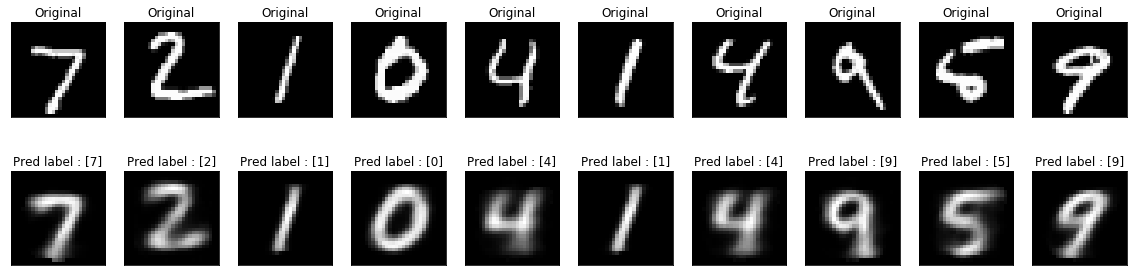

In [13]:
#Using test data.
mnist_data = MNIST('./mnist_data/', download=True, train=False,transform=transforms.ToTensor())
mnist_test   = MNIST('./mnist_data/', download=True, train=False,transform=None)

#batch size is 1 so that we can get the reconstructed image for each individual images.
mnist_dataloader = DataLoader(mnist_data, batch_size=1, shuffle=False, num_workers=1)


caps_model = caps_model.eval() #Eval mode.


reconstructed_img = []

for i, mnist_tensors in enumerate(mnist_dataloader):
    
    _,_,lbl,decoded = caps_model(mnist_tensors[0].cuda(), mnist_tensors[1].cuda())
    
    decoded = decoded.detach().cpu().numpy()
    label = lbl.detach().cpu().numpy()
    
    decoded_im = np.reshape(decoded, (28,28))
    
    reconstructed_img.append([decoded_im, np.argmax(label, axis=1)[0][0]])
    
    if i == 9:
        break

fig=plt.figure(figsize=(20, 5))
columns = 10
rows = 2
for i in range(1, columns*rows+1):
    img = None
    title = None
    if i > 10:
        title = "Pred label : " + str(reconstructed_img[i-11][1])
        img = reconstructed_img[i-11][0]
    else:
        title = "Original"
        img = mnist_test[i-1][0]

    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.xticks(())
    plt.yticks(())
plt.show()